In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time
import codecs
import sys

# (restrict tensorflow memory growth)
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

In [2]:
# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
lr = 1e-4

# problem dimensions
dim = 4
dataElements = 1 + dim*3+2500 # mapno, sample 4D, start, goal, grid

z_dim = 3 # latent
X_dim = dim # samples
y_dim = dim # reconstruction of the original point
c_dim = dataElements - dim - 1 # dimension of conditioning variable

In [3]:
# read in data from csv
filename = r'Complete_training_data_nlink_100maps.csv'
f = open(filename, 'rb')

# csv.field_size_limit(sys.maxsize)
reader = csv.reader(codecs.iterdecode(f, 'utf-8'))
count = 0
data_list = []
for row in reader:
    data_list.append(row[:dataElements])
f.close()

data = np.array(data_list, dtype='d')
numEntries = data.shape[0]
print(data[:4,:])
# import pandas as pd
# df = pd.DataFrame(data)

[[ 0.00000e+00  3.06750e+00  1.29431e+00 ...  1.00000e+00  1.00000e+00
   1.00000e+00]
 [ 0.00000e+00 -2.31125e+00 -2.01468e+00 ...  1.00000e+00  1.00000e+00
   1.00000e+00]
 [ 0.00000e+00  2.78000e-03 -1.87959e+00 ...  1.00000e+00  1.00000e+00
   1.00000e+00]
 [ 0.00000e+00 -8.04060e-01 -2.60095e+00 ...  1.00000e+00  1.00000e+00
   1.00000e+00]]


In [4]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
random_state = 42  # You can use any integer as the seed
np.random.seed(random_state)
np.random.shuffle(data)

ratioTestTrain = 0.6
numTrain = int(numEntries*ratioTestTrain)

X_train = data[:numTrain,1:1+dim] # state: joint angles
c_train = data[:numTrain,1+dim:dataElements] # start, goal, occ grid

X_test = data[numTrain:numEntries,1:1+dim]
c_test = data[numTrain:numEntries,1+dim:dataElements]
map_test = data[numTrain:numEntries,0]
numTest = X_test.shape[0]

In [5]:
# define networks
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, c_dim])

# Q
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P
eps = tf.random_normal(shape=tf.shape(z_mu))
z = z_mu + tf.exp(z_logvar / 2) * eps
inputs_P = tf.concat(axis=1, values=[z,c])

dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=X_dim) # fix to also output y

# training
w = [[1, 1, 0.5, 0.5]]
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=w)
# TODO: fix loss function for angles going around
kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
it = 0

Instructions for updating:
non-resource variables are not supported in the long term



C:\Users\vishw\AppData\Local\Temp\ipykernel_3840\1409655643.py:10: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
C:\Users\vishw\AppData\Local\Temp\ipykernel_3840\1409655643.py:11: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
C:\Users\vishw\AppData\Local\Temp\ipykernel_3840\1409655643.py:12: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)
C:\Users\vishw\AppData\Local\Temp\ipykernel_3840\1409655643.py:14: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.l

In [6]:
for it in range(it,it+400001):
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]
    X_mb = X_train[batch_elements,:]
    c_mb = c_train[batch_elements,:]

    _, loss = sess.run([train_step, cvae_loss], feed_dict={X: X_mb, c: c_mb})

    if it % 10000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print()

Iter: 0
Loss: 3.003

Iter: 10000
Loss: 0.2732

Iter: 20000
Loss: 0.1421

Iter: 30000
Loss: 0.1375

Iter: 40000
Loss: 0.1134

Iter: 50000
Loss: 0.1678

Iter: 60000
Loss: 0.1685

Iter: 70000
Loss: 0.1418

Iter: 80000
Loss: 0.1445

Iter: 90000
Loss: 0.1387

Iter: 100000
Loss: 0.1115

Iter: 110000
Loss: 0.167

Iter: 120000
Loss: 0.1372

Iter: 130000
Loss: 0.1568

Iter: 140000
Loss: 0.1502

Iter: 150000
Loss: 0.07869

Iter: 160000
Loss: 0.0707

Iter: 170000
Loss: 0.09967

Iter: 180000
Loss: 0.1136

Iter: 190000
Loss: 0.07975

Iter: 200000
Loss: 0.1037

Iter: 210000
Loss: 0.06834

Iter: 220000
Loss: 0.08366

Iter: 230000
Loss: 0.1208

Iter: 240000
Loss: 0.08363

Iter: 250000
Loss: 0.09924

Iter: 260000
Loss: 0.1307

Iter: 270000
Loss: 0.08103

Iter: 280000
Loss: 0.068

Iter: 290000
Loss: 0.07517

Iter: 300000
Loss: 0.07106

Iter: 310000
Loss: 0.07977

Iter: 320000
Loss: 0.07437

Iter: 330000
Loss: 0.07625

Iter: 340000
Loss: 0.06704

Iter: 350000
Loss: 0.06745

Iter: 360000
Loss: 0.06839

It

In [7]:
num_viz = 800

# vizIdx = randint(0,numTest-1);
# print(vizIdx)
vizIdx = 20
c_sample_seed = c_test[vizIdx,:]
# c_sample_seed[3:6] = [35, 45, 0.2]
c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})
decoder_samples = y_viz.tolist()
start = c_sample[1,:4].tolist()
goal = c_sample[1,4:8].tolist()

In [8]:
mapno = map_test[vizIdx]

In [ ]:
list_of_tuples = list(map(tuple, y_viz[:,[0,1,2,3]].tolist()))
filen = r"decodersample.txt"
with open(filen, 'w') as f:
    f.writelines(str(list_of_tuples))

In [ ]:
from map_2d import Map2D
import networkx as nx

map_2d = Map2D(r"D:\RBE Fall 2023\ML\Final Project\Kinematic_Final\Complete_training_data_nlink_50maps\map_26_nlink\map_26_nlink.csv")
ax, fig = map_2d.visualize_map(return_ax=True)
ax.scatter([start[0]],[start[1]],color='r')
ax.scatter(goal[0],goal[1],color='g')
x_vals = [point[0] for point in decoder_samples]
y_vals = [point[1] for point in decoder_samples]
ax.scatter(x_vals, y_vals,  color='y')


In [69]:
from robot import PointRobot, OmnidirectionalRobot, KinematicChain
from RRT import RRT
from PRM import PRM
from planner import Planner
from map_2d import Map2D

In [76]:
# Function to find solution with CVAE and RRT*

def draw_results(num_viz=300):
    # num_viz = 100
    vizIdx = randint(0,numTest-1);
    # print(vizIdx)
    vizIdx = 939
    c_sample_seed = c_test[vizIdx,:]
    c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
    start = c_sample[1,:4].tolist()
    goal = c_sample[1,4:8].tolist()
    # print(start)
    start = [-0.4, 0.2, 0.2, 0.2]
    # c_viz = c_gapsInitGoal[vizIdx,:]

    # directly sample from the latent space (preferred, what we will use in the end)
    y_viz, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

    mapno = map_test[vizIdx]
    mapfile = r"maps\map_%d_nlink\map_%d_nlink.csv"%(mapno,mapno)
    map_2d = Map2D(mapfile)
    configfile = r"maps\map_%d_nlink\map_%d_nlink_configs.csv"%(mapno,mapno)
    configdata = []
    with open(configfile, 'r') as f:
        reader = csv.reader(f)
        for r in reader:
            configdata.append(r)
    configdata = np.array(configdata, dtype='d')

    for idx,i in enumerate(configdata[:,2:6]):
        if i.tolist() == start:
            baseidx = idx
            break
    # base = configdata[idx,:2].tolist()
    # print(base)
    base = [13.8, 31.4]

    robot = KinematicChain(link_lengths=[8,8,8,8], base=base)

    print("Decoder sol")
    decoder_samples = list(map(tuple, y_viz[:,[0,1,2,3]].tolist()))
    start_time = time.time()
    method = PRM(sampling_method="uniform", n_configs=100, kdtree_d=np.pi, samples=decoder_samples)
    planner = Planner(method, map_2d, robot)
    decoder_sol, decoder_len = planner.plan(start, goal)
    planner.visualize(make_video=False)
    # return None, None
    end_time = time.time()
    elapsed_time_decoder = end_time - start_time

    # # try:
    print("\nRRT* sol")
    start_time = time.time()
    method = RRT(sampling_method="RRT_star", n_configs=300, kdtree_d=np.pi)
    # method = PRM(sampling_method="uniform", n_configs=100, kdtree_d=0.15, samples=decoder_samples)
    planner = Planner(method, map_2d, robot)
    rrt_sol, rrt_len = planner.plan(start, goal)
    planner.visualize(make_video=False)
    end_time = time.time()
    elapsed_time_rrt = end_time - start_time
    print("\n")
    # # except:
    # #     return None,None

    # if decoder_len == 0 or rrt_len == 0:
    #     return None, None

    # return (decoder_len, rrt_len), (elapsed_time_decoder, elapsed_time_rrt)

Decoder sol
No path found


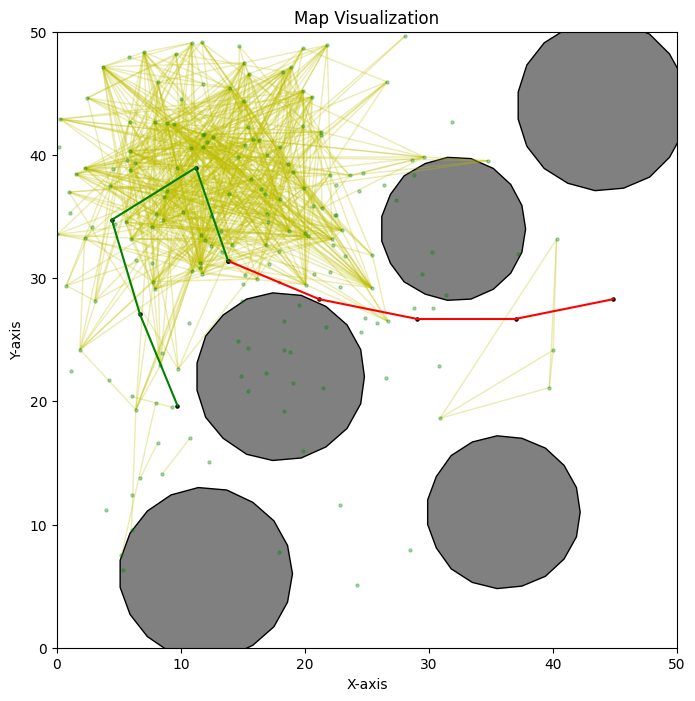


RRT* sol
The constructed tree has 300 of nodes
The path length is 19.12


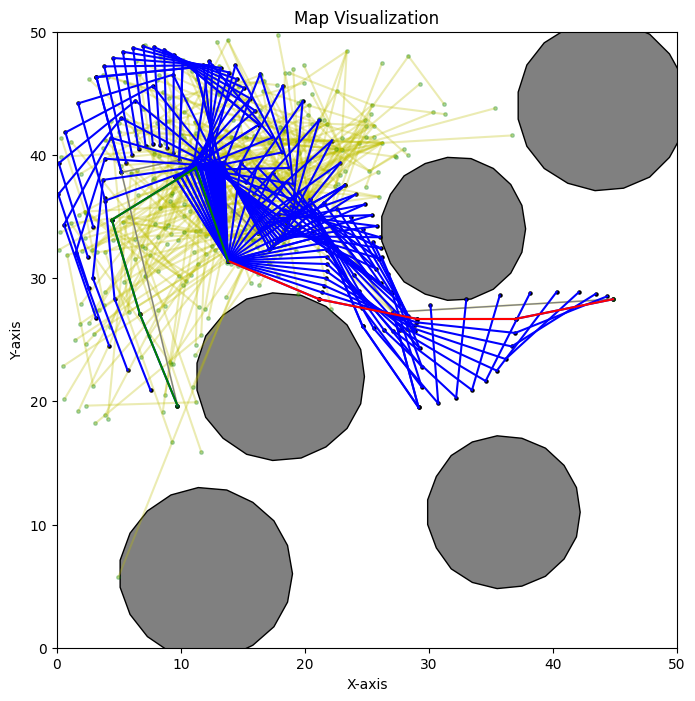

In [77]:
draw_results(100)